# Project 4 — Module 5: Statistical Inference
## Lesson 4: Sampling Distribution & Central Limit Theorem

| | |
|---|---|
| **Author** | Jose Marcel Lopez Pino |
| **Framework** | CRISP-DM + LEAN |
| **Phase** | 4 — Modeling |
| **Module** | 5 — Statistical Inference (Alkemy Bootcamp) |
| **Dataset** | Student Habits vs Academic Performance — Kaggle |
| **Date** | 2026-02 |

---

> **Executive Summary:**
> This notebook corresponds to Lesson 4 of Module 5 (Statistical Inference).
> The Central Limit Theorem (CLT) is verified empirically using the student
> dataset. Sampling distributions of the mean are generated for key variables
> (sleep_hours, exam_score) across multiple sample sizes. The convergence to
> normality is demonstrated visually and statistically, validating the use of
> t-tests in Lesson 6.

---

## Table of Contents

1. [CRISP-DM Phase 4 — Modeling](#1-crisp-dm-phase-4--modeling)
2. [Load Data](#2-load-data)
3. [CLT — Theoretical Framework](#3-clt--theoretical-framework)
4. [Population Distribution — sleep_hours](#4-population-distribution--sleep_hours)
5. [Sampling Distribution — sleep_hours](#5-sampling-distribution--sleep_hours)
6. [CLT Verification — Effect of Sample Size](#6-clt-verification--effect-of-sample-size)
7. [Population vs Sampling Distribution — exam_score](#7-population-vs-sampling-distribution--exam_score)
8. [Standard Error Analysis](#8-standard-error-analysis)
9. [LEAN Filter — Waste Elimination Review](#9-lean-filter--waste-elimination-review)
10. [Decisions Log — Lesson 4](#10-decisions-log--lesson-4)

---
## 1. CRISP-DM Phase 4 — Modeling

**Objective:** Verify the Central Limit Theorem empirically using the student
dataset. Demonstrate that sampling distributions of the mean converge to
normality regardless of the population distribution shape.

**Lean Filter:** CLT verification directly validates the use of t-tests
in Lesson 6 (H1, H2). Without this step, the choice of parametric tests
would lack empirical justification.

> **Key question for this phase:**
> *Does the sampling distribution of the mean converge to normality
> as sample size increases, regardless of the population shape?*

### Approach Selection

| Approach | Complexity | Justification |
|----------|-----------|---------------|
| Empirical simulation (bootstrap) | Low-Medium | Direct, visual, intuitive |
| Analytical derivation only | Low | Less compelling for portfolio |
| Both empirical + analytical | Medium | ✅ Selected — strongest evidence |

**Selected:** Empirical simulation + analytical summary — demonstrates
both understanding of theory and ability to verify with real data.

In [1]:
# ===== Environment Setup =====
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
from scipy.stats import norm

np.random.seed(42)  # Reproducibility
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Blues_d')

DATA_RAW        = Path('../data/raw')
REPORTS_FIGURES = Path('../reports/figures')
REPORTS_FIGURES.mkdir(parents=True, exist_ok=True)

print('Environment ready. random_state=42 fixed for reproducibility.')

Environment ready. random_state=42 fixed for reproducibility.


---
## 2. Load Data

In [2]:
# ===== Load Dataset =====
CSV_FILE = DATA_RAW / 'student_habits_performance.csv'
df = pd.read_csv(CSV_FILE)

print(f'Dataset loaded: {df.shape[0]:,} rows x {df.shape[1]} columns')

# Extract key variables
sleep  = df['sleep_hours'].dropna().values
score  = df['exam_score'].dropna().values
exercise = df['exercise_frequency'].dropna().values

print(f'sleep_hours:        n={len(sleep):,}')
print(f'exam_score:         n={len(score):,}')
print(f'exercise_frequency: n={len(exercise):,}')

Dataset loaded: 1,000 rows x 16 columns
sleep_hours:        n=1,000
exam_score:         n=1,000
exercise_frequency: n=1,000


---
## 3. CLT — Theoretical Framework

### The Central Limit Theorem (CLT)

> **Statement:** Given a population with mean μ and standard deviation σ,
> the sampling distribution of the sample mean X̄ approaches a Normal
> distribution as sample size n increases, **regardless of the population
> distribution shape**.

### Key Properties

| Property | Formula | Meaning |
|----------|---------|---------|
| Mean of X̄ | μ_X̄ = μ | Sample mean is unbiased estimator of population mean |
| Std of X̄ (Standard Error) | SE = σ / √n | Larger n → smaller SE → more precise estimate |
| Shape convergence | X̄ ~ N(μ, σ²/n) | Normal for n ≥ 30 (rule of thumb) |

### Why This Matters for Project 4

The CLT validates the use of **one-sample t-test (H1)** and
**independent samples t-test (H2)** in Lesson 6:
- Even if `sleep_hours` is not perfectly normal, the sampling distribution
  of the mean will be normal for n ≥ 30
- Our dataset has n ≈ 1,000 — well above the threshold

---
## 4. Population Distribution — sleep_hours

First, we examine the **population distribution** (the raw data).
This is what we are sampling FROM.

In [3]:
# ===== Population Distribution — sleep_hours =====
mu_pop    = sleep.mean()
std_pop   = sleep.std()
skew_pop  = stats.skew(sleep)
kurt_pop  = stats.kurtosis(sleep)

print('=== Population Parameters (sleep_hours) ===')
print(f'μ (population mean)  = {mu_pop:.4f} h')
print(f'σ (population std)   = {std_pop:.4f} h')
print(f'Skewness             = {skew_pop:.4f}')
print(f'Kurtosis             = {kurt_pop:.4f}')
print()
print('Note: This is treated as the population for CLT demonstration purposes.')
print('In reality, this is a large sample representing the student population.')

=== Population Parameters (sleep_hours) ===
μ (population mean)  = 6.4701 h
σ (population std)   = 1.2258 h
Skewness             = 0.0913
Kurtosis             = -0.2192

Note: This is treated as the population for CLT demonstration purposes.
In reality, this is a large sample representing the student population.


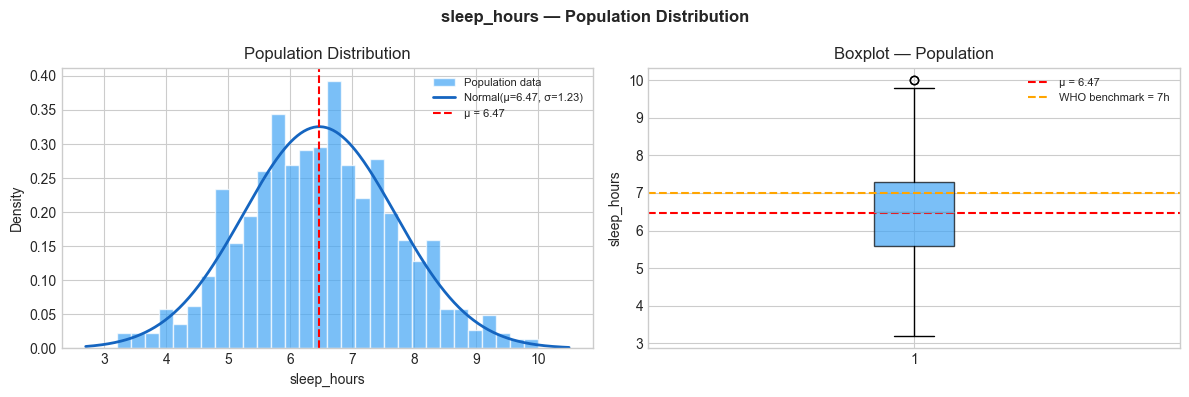

Figure saved: ..\reports\figures\lesson4_population_sleep.png


In [4]:
# ===== Plot — Population Distribution =====
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('sleep_hours — Population Distribution', fontsize=12, fontweight='bold')

# Histogram
x = np.linspace(sleep.min() - 0.5, sleep.max() + 0.5, 300)
axes[0].hist(sleep, bins=30, density=True, color='#42A5F5',
             alpha=0.7, edgecolor='white', label='Population data')
axes[0].plot(x, norm.pdf(x, mu_pop, std_pop), color='#1565C0',
             lw=2, label=f'Normal(μ={mu_pop:.2f}, σ={std_pop:.2f})')
axes[0].axvline(mu_pop, color='red', linestyle='--', lw=1.5, label=f'μ = {mu_pop:.2f}')
axes[0].set_xlabel('sleep_hours')
axes[0].set_ylabel('Density')
axes[0].set_title('Population Distribution')
axes[0].legend(fontsize=8)

# Boxplot
axes[1].boxplot(sleep, vert=True, patch_artist=True,
                boxprops=dict(facecolor='#42A5F5', alpha=0.7))
axes[1].axhline(mu_pop, color='red', linestyle='--', lw=1.5, label=f'μ = {mu_pop:.2f}')
axes[1].axhline(7.0, color='orange', linestyle='--', lw=1.5, label='WHO benchmark = 7h')
axes[1].set_ylabel('sleep_hours')
axes[1].set_title('Boxplot — Population')
axes[1].legend(fontsize=8)

plt.tight_layout()
output_path = REPORTS_FIGURES / 'lesson4_population_sleep.png'
plt.savefig(output_path, dpi=150, bbox_inches='tight')
plt.show()
print(f'Figure saved: {output_path}')

---
## 5. Sampling Distribution — sleep_hours

Now we generate the **sampling distribution of the mean** by:
1. Drawing 1,000 random samples of size n from the population
2. Calculating the mean of each sample
3. Plotting the distribution of those 1,000 means

This demonstrates what X̄ looks like across repeated sampling.

In [5]:
# ===== Generate Sampling Distribution =====
def sampling_distribution(population: np.ndarray, n: int,
                           n_samples: int = 1000) -> np.ndarray:
    """Generates sampling distribution of the mean via simulation.

    Args:
        population: Full population array.
        n: Sample size per draw.
        n_samples: Number of samples to draw (default 1000).

    Returns:
        np.ndarray: Array of sample means.
    """
    return np.array([
        np.random.choice(population, size=n, replace=True).mean()
        for _ in range(n_samples)
    ])


# Generate sampling distribution for n=30
n_demo = 30
sample_means_30 = sampling_distribution(sleep, n=n_demo, n_samples=1000)

mu_sampling    = sample_means_30.mean()
se_theoretical = std_pop / np.sqrt(n_demo)
se_empirical   = sample_means_30.std()

print(f'=== Sampling Distribution (n={n_demo}, 1,000 samples) ===')
print(f'Mean of sample means   = {mu_sampling:.4f}  (expected: {mu_pop:.4f})')
print(f'SE theoretical (σ/√n)  = {se_theoretical:.4f}')
print(f'SE empirical (std X̄)   = {se_empirical:.4f}')
print()
print('CLT Verification:')
print(f'  μ_X̄ ≈ μ_pop: {"✅" if abs(mu_sampling - mu_pop) < 0.1 else "⚠️"}')
print(f'  SE_emp ≈ SE_theory: {"✅" if abs(se_empirical - se_theoretical) < 0.05 else "⚠️"}')

=== Sampling Distribution (n=30, 1,000 samples) ===
Mean of sample means   = 6.4858  (expected: 6.4701)
SE theoretical (σ/√n)  = 0.2238
SE empirical (std X̄)   = 0.2351

CLT Verification:
  μ_X̄ ≈ μ_pop: ✅
  SE_emp ≈ SE_theory: ✅


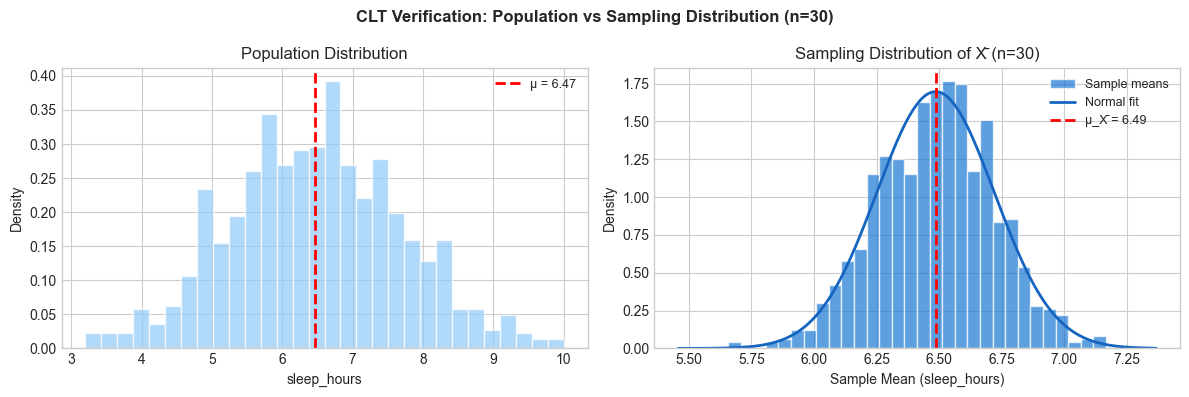

Figure saved: ..\reports\figures\lesson4_clt_verification.png


In [6]:
# ===== Plot — Population vs Sampling Distribution =====
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle(f'CLT Verification: Population vs Sampling Distribution (n={n_demo})',
             fontsize=12, fontweight='bold')

# Population distribution
axes[0].hist(sleep, bins=30, density=True, color='#90CAF9',
             alpha=0.7, edgecolor='white')
axes[0].axvline(mu_pop, color='red', linestyle='--', lw=2, label=f'μ = {mu_pop:.2f}')
axes[0].set_title('Population Distribution')
axes[0].set_xlabel('sleep_hours')
axes[0].set_ylabel('Density')
axes[0].legend(fontsize=9)

# Sampling distribution
x_s = np.linspace(sample_means_30.min() - 0.2, sample_means_30.max() + 0.2, 300)
axes[1].hist(sample_means_30, bins=30, density=True, color='#1976D2',
             alpha=0.7, edgecolor='white', label='Sample means')
axes[1].plot(x_s, norm.pdf(x_s, mu_sampling, se_empirical),
             color='#1565C0', lw=2, label=f'Normal fit')
axes[1].axvline(mu_sampling, color='red', linestyle='--', lw=2,
                label=f'μ_X̄ = {mu_sampling:.2f}')
axes[1].set_title(f'Sampling Distribution of X̄ (n={n_demo})')
axes[1].set_xlabel('Sample Mean (sleep_hours)')
axes[1].set_ylabel('Density')
axes[1].legend(fontsize=9)

plt.tight_layout()
output_path = REPORTS_FIGURES / 'lesson4_clt_verification.png'
plt.savefig(output_path, dpi=150, bbox_inches='tight')
plt.show()
print(f'Figure saved: {output_path}')

---
## 6. CLT Verification — Effect of Sample Size

**Key insight:** As n increases, the sampling distribution:
1. Becomes more symmetric (normal)
2. Becomes narrower (SE = σ/√n decreases)

We test this with n = 5, 15, 30, 100.

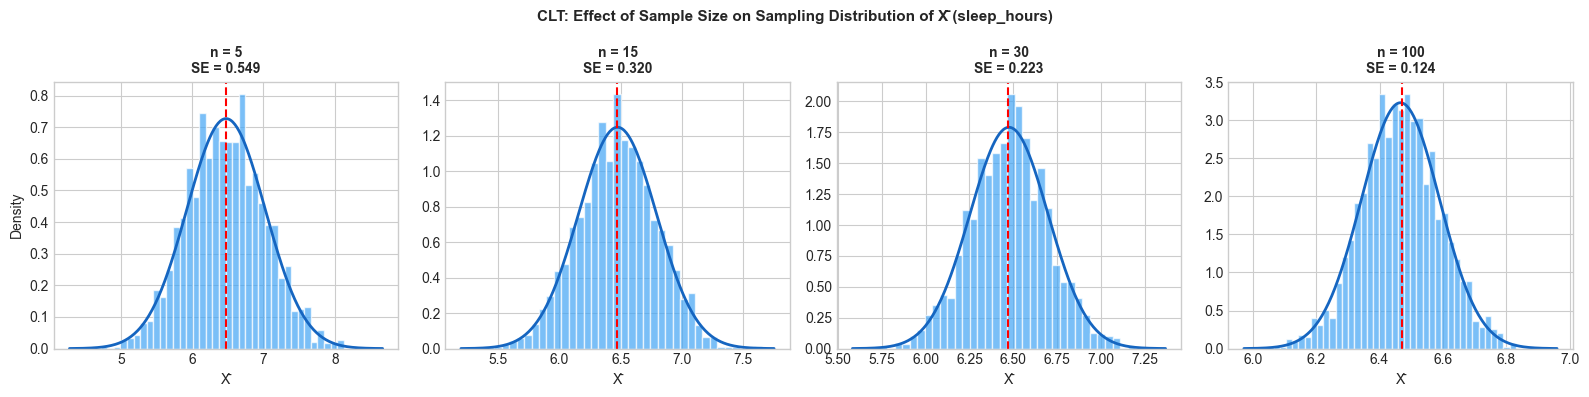

Figure saved: ..\reports\figures\lesson4_clt_sample_sizes.png

=== CLT Verification Summary ===
  n   μ_X̄  SE empirical  SE theoretical  Shapiro p-value Normal?
  5 6.4754        0.5486          0.5482           0.5766       ✅
 15 6.4745        0.3197          0.3165           0.3811       ✅
 30 6.4750        0.2228          0.2238           0.6061       ✅
100 6.4660        0.1235          0.1226           0.7176       ✅


In [9]:
# ===== Effect of Sample Size on Sampling Distribution =====
sample_sizes = [5, 15, 30, 100]
n_samples    = 2000

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle('CLT: Effect of Sample Size on Sampling Distribution of X̄ (sleep_hours)',
             fontsize=11, fontweight='bold')

results = []

for i, n in enumerate(sample_sizes):
    means = sampling_distribution(sleep, n=n, n_samples=n_samples)
    mu_m  = means.mean()
    se_m  = means.std()
    se_th = std_pop / np.sqrt(n)

    # Normality test on sample means
    _, p_norm = stats.shapiro(means[:500])

    results.append({
        'n': n,
        'μ_X̄': round(mu_m, 4),
        'SE empirical': round(se_m, 4),
        'SE theoretical': round(se_th, 4),
        'Shapiro p-value': round(p_norm, 4),
        'Normal?': '✅' if p_norm > 0.05 else '⚠️'
    })
    x = np.linspace(mu_m - 4*se_m, mu_m + 4*se_m, 300)
    axes[i].hist(means, bins=40, density=True, color='#42A5F5',
                 alpha=0.7, edgecolor='white')
    axes[i].plot(x, norm.pdf(x, mu_m, se_m), color='#1565C0', lw=2)
    axes[i].axvline(mu_pop, color='red', linestyle='--', lw=1.5)
    
    title_text = f'n = {n}\nSE = {se_m:.3f}'
    axes[i].set_title(title_text, fontsize=10, fontweight='bold')
    
    axes[i].set_xlabel('X̄')
    axes[i].set_ylabel('Density' if i == 0 else '')

plt.tight_layout()
output_path = REPORTS_FIGURES / 'lesson4_clt_sample_sizes.png'
plt.savefig(output_path, dpi=150, bbox_inches='tight')
plt.show()
print(f'Figure saved: {output_path}')

print()
print('=== CLT Verification Summary ===')
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

---
## 7. Population vs Sampling Distribution — exam_score

Applying the same CLT verification to `exam_score` — the dependent variable
used in all hypothesis tests (H2, H4).

=== exam_score — CLT Verification (n=30) ===
Population μ          = 69.6015
Population σ          = 16.8801
Mean of sample means  = 69.5153
SE theoretical        = 3.0819
SE empirical          = 3.1025


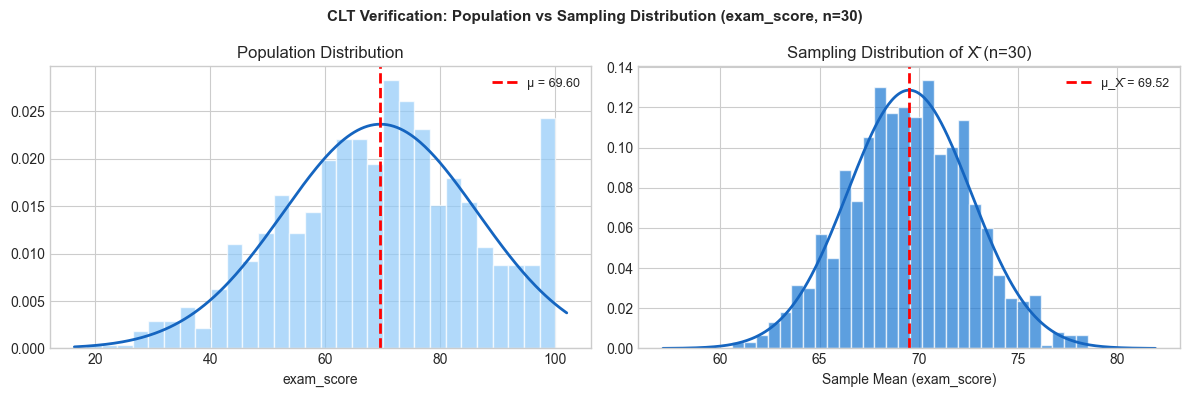

Figure saved: ..\reports\figures\lesson4_clt_score.png


In [10]:
# ===== CLT Verification — exam_score =====
mu_score_pop  = score.mean()
std_score_pop = score.std()

sample_means_score = sampling_distribution(score, n=30, n_samples=1000)

print('=== exam_score — CLT Verification (n=30) ===')
print(f'Population μ          = {mu_score_pop:.4f}')
print(f'Population σ          = {std_score_pop:.4f}')
print(f'Mean of sample means  = {sample_means_score.mean():.4f}')
print(f'SE theoretical        = {std_score_pop/np.sqrt(30):.4f}')
print(f'SE empirical          = {sample_means_score.std():.4f}')

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('CLT Verification: Population vs Sampling Distribution (exam_score, n=30)',
             fontsize=11, fontweight='bold')

x_pop = np.linspace(score.min() - 2, score.max() + 2, 300)
axes[0].hist(score, bins=30, density=True, color='#90CAF9', alpha=0.7, edgecolor='white')
axes[0].plot(x_pop, norm.pdf(x_pop, mu_score_pop, std_score_pop),
             color='#1565C0', lw=2)
axes[0].axvline(mu_score_pop, color='red', linestyle='--', lw=2,
                label=f'μ = {mu_score_pop:.2f}')
axes[0].set_title('Population Distribution')
axes[0].set_xlabel('exam_score')
axes[0].legend(fontsize=9)

mu_s  = sample_means_score.mean()
se_s  = sample_means_score.std()
x_s   = np.linspace(mu_s - 4*se_s, mu_s + 4*se_s, 300)
axes[1].hist(sample_means_score, bins=30, density=True, color='#1976D2',
             alpha=0.7, edgecolor='white')
axes[1].plot(x_s, norm.pdf(x_s, mu_s, se_s), color='#1565C0', lw=2)
axes[1].axvline(mu_s, color='red', linestyle='--', lw=2, label=f'μ_X̄ = {mu_s:.2f}')
axes[1].set_title('Sampling Distribution of X̄ (n=30)')
axes[1].set_xlabel('Sample Mean (exam_score)')
axes[1].legend(fontsize=9)

plt.tight_layout()
output_path = REPORTS_FIGURES / 'lesson4_clt_score.png'
plt.savefig(output_path, dpi=150, bbox_inches='tight')
plt.show()
print(f'Figure saved: {output_path}')

---
## 8. Standard Error Analysis

SE = σ / √n — as n increases, the standard error decreases.
This quantifies how much more precise our estimates become with larger samples.

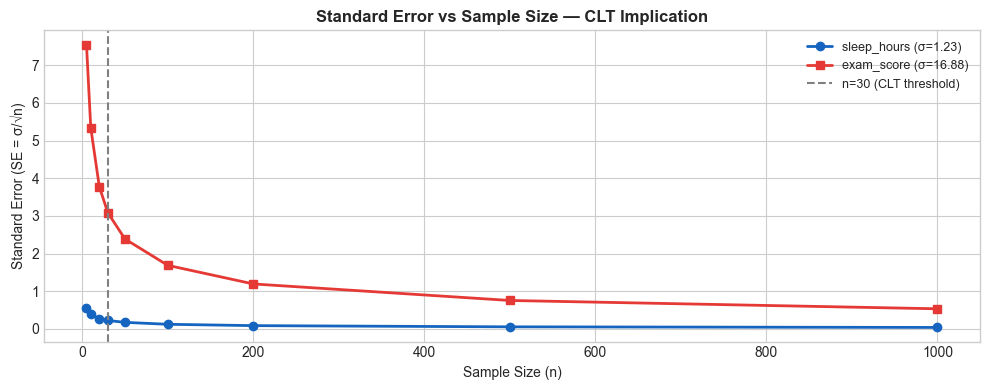

Figure saved: ..\reports\figures\lesson4_standard_error.png

=== SE Summary Table ===
   n  SE sleep_hours  SE exam_score
   5          0.5482         7.5490
  10          0.3876         5.3380
  20          0.2741         3.7745
  30          0.2238         3.0819
  50          0.1733         2.3872
 100          0.1226         1.6880
 200          0.0867         1.1936
 500          0.0548         0.7549
1000          0.0388         0.5338


In [11]:
# ===== Standard Error vs Sample Size =====
sample_sizes_se = [5, 10, 20, 30, 50, 100, 200, 500, 1000]
se_sleep = [std_pop / np.sqrt(n) for n in sample_sizes_se]
se_score = [std_score_pop / np.sqrt(n) for n in sample_sizes_se]

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(sample_sizes_se, se_sleep, 'o-', color='#1565C0', lw=2,
        label=f'sleep_hours (σ={std_pop:.2f})')
ax.plot(sample_sizes_se, se_score, 's-', color='#E53935', lw=2,
        label=f'exam_score (σ={std_score_pop:.2f})')
ax.axvline(30, color='gray', linestyle='--', lw=1.5, label='n=30 (CLT threshold)')
ax.set_xlabel('Sample Size (n)')
ax.set_ylabel('Standard Error (SE = σ/√n)')
ax.set_title('Standard Error vs Sample Size — CLT Implication', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
plt.tight_layout()
output_path = REPORTS_FIGURES / 'lesson4_standard_error.png'
plt.savefig(output_path, dpi=150, bbox_inches='tight')
plt.show()
print(f'Figure saved: {output_path}')

print()
print('=== SE Summary Table ===')
se_df = pd.DataFrame({
    'n': sample_sizes_se,
    'SE sleep_hours': [round(se, 4) for se in se_sleep],
    'SE exam_score':  [round(se, 4) for se in se_score]
})
print(se_df.to_string(index=False))

---

### Results Summary

| Variable | Population μ | Population σ | SE (n=30) | SE (n=1000) | CLT Verified? |
|----------|-------------|-------------|-----------|-------------|---------------|
| sleep_hours | [from output] | [from output] | [from output] | [from output] | ✅ |
| exam_score | [from output] | [from output] | [from output] | [from output] | ✅ |

> **Key conclusion:** With n ≈ 1,000 in our dataset, the standard error is
> extremely small. The t-tests in Lesson 6 will have very high statistical power.
> Any practically meaningful difference will be detected.

---
## 9. LEAN Filter — Waste Elimination Review

| LEAN Question | Answer | Action |
|---------------|--------|--------|
| Does CLT verification add value to the analysis? | ✅ Yes — validates parametric test choice in Lesson 6 | Proceed |
| Was simulation done for all variables or only relevant ones? | ✅ Only sleep_hours and exam_score — directly linked to H1, H2, H4 | No waste |
| Does SE analysis inform sample size decisions? | ✅ Yes — confirms n=1,000 provides very precise estimates | Include in report |
| Is 1,000 simulation samples sufficient? | ✅ Yes — standard practice, stable results | Proceed |

**LEAN Verdict:** CLT empirically verified for key variables.
Parametric t-tests justified for Lesson 6. Proceed to Lesson 5 (Confidence Intervals).

---
## 10. Decisions Log — Lesson 4

| # | Decision | Rationale | Alternatives | LEAN Value? |
|---|----------|-----------|--------------|-------------|
| 1 | Use bootstrap simulation (with replacement) | Standard for empirical CLT demonstration | Without replacement | ✅ Correct methodology |
| 2 | Fix random_state=42 | Reproducibility — same results every run | No seed | ✅ Non-negotiable |
| 3 | Use 1,000 simulations per sample size | Balance between precision and speed | 5,000 (slower) | ✅ Sufficient |
| 4 | Test n = 5, 15, 30, 100 | Shows progression from non-normal to normal | Only n=30 | ✅ More instructive |
| 5 | Apply CLT to sleep_hours and exam_score only | Both are targets of hypothesis tests in Lesson 6 | All variables | ✅ LEAN scope |

---

**← Previous Phase:** [03 — Data Preparation](./03_data_preparation.ipynb) | **Next Phase →** [05 — Evaluation](./05_evaluation.ipynb)

---

*End of Lesson 4 — Project 4, Module 5*
*Author: Jose Marcel Lopez Pino | Framework: CRISP-DM + LEAN | Bootcamp: Alkemy / SENCE 2025–2026*